In [ ]:
from utils import list_images, generate_multichannel_tif
from cellpose import models, core
import numpy as np
from tifffile import imread, imwrite
from pathlib import Path
from skimage.measure import regionprops_table
import napari
import pandas as pd
from scipy import stats

# Ignore OME-TIFF warnings during imread
import logging
logging.getLogger("tifffile").setLevel(logging.ERROR)

#Check if notebook has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

#Load pre-trained Cellpose-SAM
model = models.CellposeModel(gpu=True)

In [2]:
# Copy the path to the folder containing your images in between the quotation marks
data_folder = r"Z:\MariiaY\Evos Anna nanoparticles\Ex7_neg_LNPs_.2025-11-27-11-47-57"

# If the path is correct you should see a list of the first 10 images in your folder down below
images = list_images(data_folder, format="tif")
images[:10]

['Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f00d1.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f00d2.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f00d4.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f01d1.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f01d2.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f01d4.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f02d1.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.2025-11-27-11-47-57\\Ex7_neg_LNPs__Plate_D_p00_0_B01f02d2.TIF',
 'Z:\\MariiaY\\Evos Anna nanoparticles\\Ex7_neg_LNPs_.20

In [ ]:
# Process single channel .tif files into multichannel .tif files and save them
generate_multichannel_tif(data_folder)

In [ ]:
# Extract experiment_id from data folder Path object
experiment_id = Path(data_folder).name
experiment_id

In [3]:
processed_img_path = "./processed_tiffs"
processed_images = list_images(processed_img_path, format="tif")

In [4]:
img = imread(processed_images[14])

In [5]:
field_of_view = Path(processed_images[14]).stem.split("f")[1]
well_id = Path(processed_images[14]).stem.split("f")[0]

# Create a dictionary containing all image descriptors
descriptor_dict = {"well_id": well_id, "FOV": field_of_view}

print(field_of_view, well_id)

02 A02


In [6]:
# Predict nuclei labels using CellposeSAM and simulate cytosol using pyclesperanto
nuclei_labels, flows, styles = model.eval(img[1], niter=1000) # need to check the arguments

# Predict cytoplasm labels using CellposeSAM using nuclei (1) and brightfield (2) images as input 
cytoplasm_labels, flows, styles = model.eval((img[[1,2]]), niter=1000) # need to check the arguments


In [7]:
# Visualize results in Napari
viewer = napari.Viewer(ndisplay=2)
viewer.add_image(img)
viewer.add_labels(nuclei_labels)
viewer.add_labels(cytoplasm_labels)

<Labels layer 'cytoplasm_labels' at 0x1d048eec820>

In [ ]:
# Label-to-label remapping: each nucleus inherits the cytoplasm label value it lies in
# Might cause soe issues with multinucleated cells (will try to filter them out later)

out = np.zeros_like(nuclei_labels)

for nid in np.unique(nuclei_labels):
    if nid == 0:
        continue
    
    mask = nuclei_labels == nid
    cyto_vals = cytoplasm_labels[mask]
    cyto_vals = cyto_vals[cyto_vals != 0]  # ignore background
    
    if len(cyto_vals) == 0:
        continue
    
    cyto_id = stats.mode(cyto_vals, keepdims=False).mode
    out[mask] = cyto_id


In [15]:
viewer.add_labels(out)

<Labels layer 'out' at 0x1d065700fa0>

In [16]:
props_list = []

# Extract nuclei avg_int
props = regionprops_table(label_image=out,
                        intensity_image=img[0],
                        properties=["label", "intensity_mean", "area"])

# Convert to dataframe
props_df = pd.DataFrame(props)

# Rename intensity_mean column to indicate the specific image
props_df.rename(columns={"intensity_mean": f"nuclei_avg_int"}, inplace=True)
props_df.rename(columns={"area": f"nuclei_area"}, inplace=True)

# Append each props_df to props_list
props_list.append(props_df)


# Extract cytoplasm avg_int
props = regionprops_table(label_image=cytoplasm_labels,
                        intensity_image=img[0],
                        properties=["label", "intensity_mean", "area"])

# Convert to dataframe
props_df = pd.DataFrame(props)

# Rename intensity_mean column to indicate the specific image
props_df.rename(columns={"intensity_mean": f"cytoplasm_avg_int"}, inplace=True)
props_df.rename(columns={"area": f"cytoplasm_area"}, inplace=True)

# Append each props_df to props_list
props_list.append(props_df)

In [28]:
# Initialize the df with the first df in the list
props_df = props_list[0]
# Start looping from the second df in the list
for df in props_list[1:]:
    props_df = props_df.merge(df, on="label")

# Add each key-value pair from descriptor_dict to props_df at the specified position
insertion_position = 0
for key, value in descriptor_dict.items():
    props_df.insert(insertion_position, key, value)
    insertion_position += 1  # Increment position to maintain the order of keys in descriptor_dict

props_df

,well_id,FOV,label,nuclei_avg_int,nuclei_area,cytoplasm_avg_int,cytoplasm_area
0,A02,02,3,25.904762,357.0,27.405460,989.0
1,A02,02,4,50.257143,105.0,36.711538,416.0
2,A02,02,7,57.235294,51.0,41.908356,371.0
3,A02,02,8,41.321149,383.0,52.658385,1449.0
4,A02,02,9,28.234463,354.0,29.784946,558.0
...,...,...,...,...,...,...,...
830,A02,02,863,26.855895,229.0,27.423520,1301.0
831,A02,02,864,28.256000,375.0,37.538005,842.0
832,A02,02,865,28.984190,253.0,30.715110,867.0
833,A02,02,866,25.173913,207.0,31.555305,443.0


In [29]:
props_df["nuclei_cyto_ratio"] = props_df["nuclei_area"] / props_df["cytoplasm_area"]
props_df

,well_id,FOV,label,nuclei_avg_int,nuclei_area,cytoplasm_avg_int,cytoplasm_area,nuclei_cyto_ratio
0,A02,02,3,25.904762,357.0,27.405460,989.0,0.360971
1,A02,02,4,50.257143,105.0,36.711538,416.0,0.252404
2,A02,02,7,57.235294,51.0,41.908356,371.0,0.137466
3,A02,02,8,41.321149,383.0,52.658385,1449.0,0.264320
4,A02,02,9,28.234463,354.0,29.784946,558.0,0.634409
...,...,...,...,...,...,...,...,...
830,A02,02,863,26.855895,229.0,27.423520,1301.0,0.176018
831,A02,02,864,28.256000,375.0,37.538005,842.0,0.445368
832,A02,02,865,28.984190,253.0,30.715110,867.0,0.291811
833,A02,02,866,25.173913,207.0,31.555305,443.0,0.467269


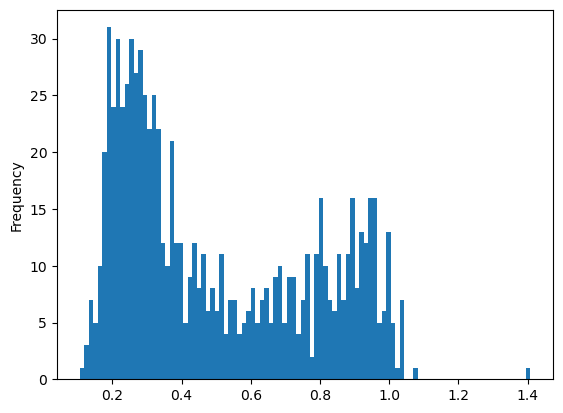

In [21]:
import matplotlib.pyplot as plt
props_df["nuclei_cyto_ratio"].dropna().plot.hist(bins=100)
plt.show()



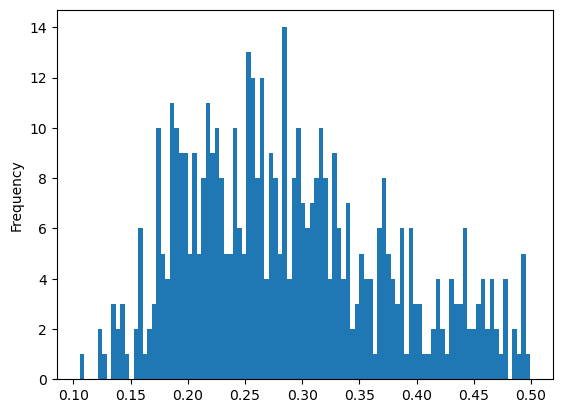

In [30]:
props_df = props_df[props_df["nuclei_cyto_ratio"] <= 0.5]

import matplotlib.pyplot as plt
props_df["nuclei_cyto_ratio"].dropna().plot.hist(bins=100)
plt.show()


In [32]:
import numpy as np

# Collect valid labels
valid_labels = props_df["label"].values

# Mask nuclei_labels: keep only valid labels
nuclei_labels_filtered = out.copy()
nuclei_labels_filtered[~np.isin(nuclei_labels_filtered, valid_labels)] = 0

viewer.add_labels(nuclei_labels_filtered)

<Labels layer 'nuclei_labels_filtered' at 0x1d06a3d5f00>

In [36]:
cytoplasm_labels_filtered = cytoplasm_labels.copy()
cytoplasm_labels_filtered[~np.isin(cytoplasm_labels_filtered, valid_labels)] = 0

viewer.add_labels(cytoplasm_labels_filtered)


<Labels layer 'cytoplasm_labels_filtered' at 0x1d048eed540>